In [1]:
import numpy as np

# Predict Air Pollution II - predict sequences

#### Exercise objectives
- Work with sequences of different lengths
- Use RNNs to return outputs for each observation in the sequences

<hr>

This exercise is a little bit different from the previous one: Here, you **observe _only_ the weather features (not the pollution)**, and you will **predict one value of air pollution *for each observation* in the input sequence**. 

What is the use-case? 
- Let's say that you have devices that are able to measure the air pollution in some places and to relate it to some weather features. That is fine! 
- But in another place, you have only weather measurements and no way to measure the air pollution.
- Then, you will use the relation between the weather features and the air pollution in some places to be able to predict the air pollution based on the weather features in another places. 

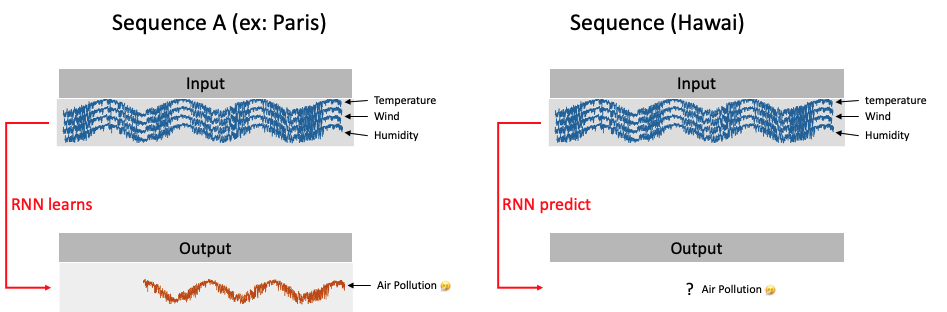

## 1. Data

👇 We load below the same dataset than in previous challenge. `pm2.5` is your target column. This time, it will not be a feature

In [2]:
import pandas as pd
df = pd.read_csv('data.txt', index_col=[0])
df = df[['pm2.5', 'TEMP', 'DEWP', 'PRES', 'Ir', 'Is', 'Iws']]
df

,pm2.5,TEMP,DEWP,PRES,Ir,Is,Iws
No,,,,,,,
1,NaN,-11.0,-21,1021.0,0,0,1.79
2,NaN,-12.0,-21,1020.0,0,0,4.92
3,NaN,-11.0,-21,1019.0,0,0,6.71
4,NaN,-14.0,-21,1019.0,0,0,9.84
5,NaN,-12.0,-20,1018.0,0,0,12.97
...,...,...,...,...,...,...,...
43820,8.0,-2.0,-23,1034.0,0,0,231.97
43821,10.0,-3.0,-22,1034.0,0,0,237.78
43822,10.0,-3.0,-22,1034.0,0,0,242.70


We separate `df` into `df_train` and `df_test` such that the first 80% of the dataframe are in the training. And the last 20% in the test set. We also scale the data so as to have them in the same range

In [3]:
# Time Serie split
split_size = int(len(df) * 0.8)
df_train, df_test = df[:split_size], df[split_size:]
df_train.head()

,pm2.5,TEMP,DEWP,PRES,Ir,Is,Iws
No,,,,,,,
1,NaN,-11.0,-21,1021.0,0,0,1.79
2,NaN,-12.0,-21,1020.0,0,0,4.92
3,NaN,-11.0,-21,1019.0,0,0,6.71
4,NaN,-14.0,-21,1019.0,0,0,9.84
5,NaN,-12.0,-20,1018.0,0,0,12.97


In [4]:
# Scale with MinMaxScale
from sklearn.preprocessing import MinMaxScaler
columns = df.columns

scaler = MinMaxScaler()
df_train = pd.DataFrame(scaler.fit_transform(df_train), columns=columns)
df_test = pd.DataFrame(scaler.transform(df_test), columns=columns)
df_train.head()

,pm2.5,TEMP,DEWP,PRES,Ir,Is,Iws
0,NaN,0.133333,0.196721,0.545455,0.0,0.0,0.002290
1,NaN,0.116667,0.196721,0.527273,0.0,0.0,0.007639
2,NaN,0.133333,0.196721,0.509091,0.0,0.0,0.010698
3,NaN,0.083333,0.196721,0.509091,0.0,0.0,0.016047
4,NaN,0.116667,0.213115,0.490909,0.0,0.0,0.021396


## 2. Prepare sequences

### 2.1 Create (X,y)

Reuse your functions from previous challenge to answer this new one:

❓ **Question** ❓ Write a function `get_X_y(df, sequence_lengths)` that, given a input dataframe `df`, returns a dataset `(X, y)` where `X` are sequences of observations and `y` are their related pollution levels.

- Each observation corresponds to the weather features : TEMP, DEWP, PRES, Ir, Is, Iws. 
- If a sequence input contains `n` observations from Day `i` to Day `i+n`, then the corresponding values to predict are the sequence of pollution levels from Day `i` to Day `i+n` too.

❗ **Remark 1** In the last exercise, all the sequences had the same lengths. Here, they change with respect to the `sequence_lengths` argument, which is a list of integers:
- For instance, if `sequence_lengths = [7, 9, 6]`, $X$ will corresponds to three sequences: the first one with 7 observations, the second one with 9 observations and the third one with 6 observations.
- the length of `sequence_lengths` corresponds to the number of sequence you want to subsample from your initial sequence
- the $i$-th value of `sequence_lengths` corresponds to the length of the $i$-th sequence.

❗ **Remark 2** You are free to do whatever you want with the missing values that are in the inputs and outputs. The idea is not to spend much time on them but to get usable data.

In [5]:
df_train

,pm2.5,TEMP,DEWP,PRES,Ir,Is,Iws
0,NaN,0.133333,0.196721,0.545455,0.0,0.0,0.002290
1,NaN,0.116667,0.196721,0.527273,0.0,0.0,0.007639
2,NaN,0.133333,0.196721,0.509091,0.0,0.0,0.010698
3,NaN,0.083333,0.196721,0.509091,0.0,0.0,0.016047
4,NaN,0.116667,0.213115,0.490909,0.0,0.0,0.021396
...,...,...,...,...,...,...,...
35054,0.022133,0.466667,0.229508,0.363636,0.0,0.0,0.124515
35055,0.019115,0.466667,0.245902,0.381818,0.0,0.0,0.141314
35056,0.016097,0.466667,0.245902,0.381818,0.0,0.0,0.158113
35057,0.021127,0.450000,0.229508,0.381818,0.0,0.0,0.174912


In [6]:
def compute_means(X, df_mean):
    # Compute means of X
    means = X.mean()

    # Case if ALL values of at least one feature of X are NaN,
    # then reaplace with the whole df_mean
    if means.isna().sum() != 0:
        means.fillna(df_mean, inplace=True)

    return means

def subsample_sequence(df, sequence_length):
    """
    Given the initial dataframe `df`, return a shorter dataframe sequence of length `length`.
    This shorter sequence should be selected at random
    """
    # if the requested length is greater than or equal to the length of the dataframe
    if sequence_length >= df.shape[0]:
        return df  
    
    # randomly sample `length` rows from the dataframe
    df_sample = df.sample(n=sequence_length)  
    df_sample = df_sample.sort_index() 
    return df_sample


def split_subsample_sequence(df, length, df_mean=None):
    '''Return one single random sample (X_sample, y_sample) containing one sequence each of length `length`'''
    # Trick to save time during potential recursive calls
    if df_mean is None:
        df_mean = df.mean()
        
    df_subsample = subsample_sequence(df, length)    
    y_sample = df_subsample["pm2.5"].iloc[:-1]
    # Case y_sample is NaN: redraw !
    if y_sample.isna().any(): 
            X_sample, y_sample = split_subsample_sequence(df, length, df_mean) # Recursive call !!!
            return np.array(X_sample), np.array(y_sample)

    X_sample = df_subsample[0:length-1]
    # Case X_sample has some NaNs
    if X_sample.isna().sum().sum() !=0:
        X_sample = X_sample.fillna(compute_means(X_sample, df_mean))
        X_sample = X_sample.values
        
    
    return np.array(X_sample), np.array(y_sample)
    

        
def get_X_y(df, sequence_lengths):
    ''' returns a dataset `(X, y)` where `X` are a list of sequences of observations, and `y` are their related pollution levels'''
    X = []
    y = []
    for index, seq in enumerate(sequence_lengths):     
        X_sample, y_sample = split_subsample_sequence(df, seq)
        X_sample = X_sample[:, 1:]
        X.append(X_sample)
        y.append(y_sample)    
#     return np.array(X, dtype=object), np.array(y, dtype=object)
    return X, y

In [7]:
X,y = get_X_y(df_train, [5])
print(X)
print("\n",y)

[array([[9.16666667e-01, 9.01639344e-01, 1.09090909e-01, 0.00000000e+00,
        0.00000000e+00, 1.29710331e-02],
       [1.66666667e-01, 3.11475410e-01, 6.72727273e-01, 0.00000000e+00,
        0.00000000e+00, 2.29001111e-03],
       [6.83333333e-01, 9.01639344e-01, 2.72727273e-01, 0.00000000e+00,
        0.00000000e+00, 7.51943946e-04],
       [7.00000000e-01, 4.75409836e-01, 4.54545455e-01, 0.00000000e+00,
        0.00000000e+00, 2.97872340e-02]])]

 [array([0.19919517, 0.07444668, 0.07444668, 0.0110664 ])]


👇 Test your code below

In [8]:
# Here we define the parameter to generate our train/test sets
train_size = 1000
test_size = round(0.2 * train_size)

min_seq_len = 15
max_seq_len = 30

In [9]:
# Let's generate some train/test sets
sequence_lengths_train = np.random.randint(low=min_seq_len, high=max_seq_len, size=train_size)
X_train, y_train = get_X_y(df_train, sequence_lengths_train)

sequence_lengths_test = np.random.randint(low=min_seq_len, high=max_seq_len, size=test_size)
X_test, y_test = get_X_y(df_test, sequence_lengths_test)

In [10]:
# Test if there are no NaN in you dataset
assert np.sum([np.isnan(x[0]).sum() for x in X_train]) == 0
assert np.sum([np.isnan(x[0]).sum() for x in X_test]) == 0


In [11]:
assert np.sum([np.isnan(y).sum() for y in y_train]) == 0
assert np.sum([np.isnan(y).sum() for y in y_test]) == 0

# Check your shapes
print("X_train type", type(X_train))
print("n_sequence", len(X_train))
print("shape sequence 0", X_train[0].shape)
print("shape sequence 1", X_train[1].shape)
print("...")
print("\n")
print("y_train type", type(y_train))
print("n_sequence", len(X_train))
print("shape sequence 0", X_train[0].shape)
print("shape sequence 1", X_train[1].shape)
print("...")

X_train type <class 'list'>
n_sequence 1000
shape sequence 0 (27, 6)
shape sequence 1 (21, 6)
...


y_train type <class 'list'>
n_sequence 1000
shape sequence 0 (27, 6)
shape sequence 1 (21, 6)
...


☝️ It should look something like (with different sequence lenghts of course)
```
X_train type <class 'list'>
n_sequence 1000
shape sequence 0 (27, 6)
shape sequence 1 (18, 6)
...


y_train type <class 'list'>
n_sequence 1000
shape sequence 0 (27, 6)
shape sequence 1 (18, 6)
...

```

### 2.2 Padding

❓ **Question** ❓ Your input sequences have different lengths. For this reason, do not forget to pad them. For the model to work, you also need to pad your target values `y_train` and `y_test`.

You need all your sequences (train and test, X **and** y) to be of same length (not only X!). To do so, use the `maxlen=30` keyword - [see documentation](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences)

In [12]:
# YOUR CODE HERE
from tensorflow.keras.preprocessing.sequence import pad_sequences

def apply_padding(sequences) :
#     sequences = sequences.values.tolist()
    padded_sequences = pad_sequences(
        sequences,
        dtype='float32',
        padding='post',
        value=-1.0,
        maxlen=30
    )
    return padded_sequences

X_train_pad = apply_padding(X_train)
y_train_pad = apply_padding(y_train)
X_test_pad = apply_padding(X_test)
y_test_pad = apply_padding(y_test)


## 3. Model

❓ **Question** ❓ 
- Initialize the model of your choice here. But don't forget, you have to return a sequence of outputs!
- Do not forget to mask the padded values. You only need to do that for the inputs. Use the padded targets as normal targets, as they won't even be used for the loss computation anyway.
- Fit it and compare your prediction to a benchmark prediction

- Fine-tune your model by adjusting the different hyperparameters of by stacking different RNNs. You should be able to reach a MAE of about `0.05` on the test set

In [13]:
print(X_train_pad.shape)
print(y_train_pad.shape)
print(X_test_pad.shape)
print(y_test_pad.shape)

(1000, 30, 6)
(1000, 30)
(200, 30, 6)
(200, 30)


In [14]:
#create a false set of prediction based on the mean of pollution
benchmark = y_train_pad.mean()
mae_benchmark = np.abs(y_test_pad - benchmark).mean()
print("Benchmark MAE:", mae_benchmark)

Benchmark MAE: 0.4564738


In [44]:
from tensorflow.keras.layers import Masking
from keras.models import Sequential
from keras.layers import Dense, GRU, Dropout, LSTM
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt


def init_model(X_train_pad):
    model = Sequential([
        Masking(mask_value= -1, input_shape=(X_train_pad.shape[1],X_train_pad.shape[2])),
        LSTM(256, return_sequences=True, activation='tanh', input_shape=(X_train_pad.shape[1],X_train_pad.shape[2])),
        LSTM(128, return_sequences=True, activation='tanh'),
        LSTM(64, activation='tanh'),
        Dense(50, activation='relu'),
        Dense(30, activation='linear'),
    ])
    model.compile(loss= 'mse', optimizer =RMSprop(learning_rate=0.0001), metrics=['mae'])
    model.summary()
    return model


# YOUR CODE HERE
def launch_model(model, X_train_pad, y_train_pad):
    
    # YOUR CODE HERE
    early_stopping = EarlyStopping(
        monitor="val_loss",
        min_delta=0.001, # minimium amount of change to count as an improvement
        patience=10,# how many epochs to wait before stopping
        restore_best_weights=True,    
        )
    
    return model.fit(X_train_pad, y_train_pad,
        batch_size=16,
         epochs=100,
        callbacks=[early_stopping],
         validation_split=0.2,
         )


def plot_history(history) :
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Valid'])
    plt.show()
    
def get_test_model(X_test, y_test) :
    predictions = model.predict(X_test)
    return predictions, np.abs(y_test - predictions).mean()


In [45]:
# YOUR CODE HERE
model = init_model(X_train_pad)
history = launch_model(model, X_train_pad, y_train_pad)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_4 (Masking)         (None, 30, 6)             0         
                                                                 
 lstm_12 (LSTM)              (None, 30, 256)           269312    
                                                                 
 lstm_13 (LSTM)              (None, 30, 128)           197120    
                                                                 
 lstm_14 (LSTM)              (None, 64)                49408     
                                                                 
 dense_6 (Dense)             (None, 50)                3250      
                                                                 
 dense_7 (Dense)             (None, 30)                1530      
                                                                 
Total params: 520,620
Trainable params: 520,620
Non-tr

50/50 [==============================] - 3s 54ms/step - loss: 0.0180 - mae: 0.0854 - val_loss: 0.0174 - val_mae: 0.0857
Epoch 54/100
50/50 [==============================] - 3s 57ms/step - loss: 0.0178 - mae: 0.0851 - val_loss: 0.0227 - val_mae: 0.0906
Epoch 55/100
50/50 [==============================] - 3s 53ms/step - loss: 0.0175 - mae: 0.0845 - val_loss: 0.0215 - val_mae: 0.0894
Epoch 56/100
50/50 [==============================] - 3s 52ms/step - loss: 0.0177 - mae: 0.0846 - val_loss: 0.0173 - val_mae: 0.0855
Epoch 57/100
50/50 [==============================] - 3s 52ms/step - loss: 0.0176 - mae: 0.0845 - val_loss: 0.0185 - val_mae: 0.0856
Epoch 58/100
50/50 [==============================] - 3s 52ms/step - loss: 0.0174 - mae: 0.0840 - val_loss: 0.0166 - val_mae: 0.0840
Epoch 59/100
50/50 [==============================] - 3s 52ms/step - loss: 0.0176 - mae: 0.0840 - val_loss: 0.0182 - val_mae: 0.0853


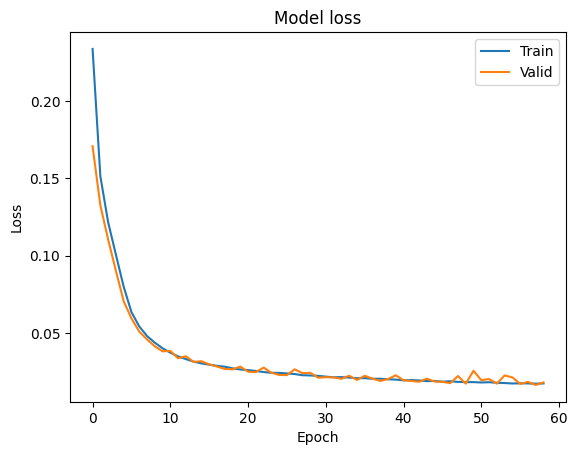

In [46]:
plot_history(history)

In [47]:
preds, mae = get_test_model(X_test_pad, y_test_pad)
print('Score to beat :', mae_benchmark )
print('Score on test set :', mae)
    

7/7 [==============================] - 4s 30ms/step
Score to beat : 0.4564738
Score on test set : 0.085145205


❓ **Question** ❓ Plot many true sequences, as well as their predictions, to visualize your model performance

In [48]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}    

<IPython.core.display.Javascript object>

In [49]:
import plotly.graph_objs as go


def plot_sequences(nb, y_pred, y_true) :
    
    for i in range(nb):
        trace1 = go.Scatter(
            x = list(range(len(y_pred[i]))),
            y = y_pred[i],
            name = 'Predicted'
        )
        trace2 = go.Scatter(
            x = list(range(len(y_true[i]))),
            y = y_true[i],
            name = 'True'
        )
        layout = go.Layout(
            title = f'Sequence {i+1}',
            xaxis = dict(title = 'Time'),
            yaxis = dict(title = 'Value')
        )
        fig = go.Figure(data=[trace1, trace2], layout=layout)
        fig.show()



nb_sequences_to_plot = 10
plot_sequences(nb_sequences_to_plot, preds, y_test_pad)


🏁 **Congratulation**